<a href="https://colab.research.google.com/github/freirepablo/Mango_Leaf_Disease_Classification/blob/main/Xception_(Cross-Validation).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from keras import layers, models, optimizers
from keras.optimizers import RMSprop
from keras.layers import Input, Lambda, Dense, Flatten, GlobalAveragePooling2D
from keras.models import Model
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from sklearn.model_selection import StratifiedKFold
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import keras
from keras.callbacks import ModelCheckpoint

In [ ]:
train_path = '/content/drive/MyDrive/Dataset/Treino'
test_path = '/content/drive/MyDrive/Dataset/Validação'

In [ ]:
batch_size = 32
img_size = (224, 224)
epochs = 35

In [ ]:
folders = glob('/content/drive/MyDrive/Dataset/Treino/*')
labels = [os.path.basename(folder) for folder in folders]
print(labels)

NameError: ignored

In [ ]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [ ]:
# Carregar modelo Xception com pesos pré-treinados
xception = Xception(include_top=False, weights='imagenet', input_shape=(299, 299, 3))

# Congelar camadas convolucionais do modelo base
for layer in xception.layers:
    layer.trainable = False

x = xception.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x)

model = Model(inputs=xception.input, outputs=predictions)

model.compile(optimizer=RMSprop(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

83683744/83683744 [==============================] - 5s 0us/step


In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
for fold, (train_index, test_index) in enumerate(skf.split(folders, np.zeros(len(folders)))):
    print(f"Fold {fold + 1}")

    # Criar geradores de treino e teste para o fold atual
    #train_folders = np.array(folders)[train_index]
    #test_folders = np.array(folders)[test_index]

    train_generator = train_datagen.flow_from_directory(train_path,
                                                     target_size=(224, 224),
                                                     batch_size=batch_size,
                                                     class_mode='categorical')

    test_generator = test_datagen.flow_from_directory(test_path,
                                                    target_size=(224, 224),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

    # Criar um novo modelo para cada fold
    model = Model(inputs=xception.input, outputs=predictions)
    model.compile(optimizer=RMSprop(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Callback para salvar o melhor modelo para cada fold
    checkpoint = keras.callbacks.ModelCheckpoint(f'xception_fold_{fold + 1}.h5',
                                                    monitor='val_accuracy',
                                                    save_best_only=True,
                                                    mode='max',
                                                    verbose=1)

    # Treinar o modelo para o fold atual
    history = model.fit(train_generator,
                        epochs=epochs,
                        validation_data=test_generator,
                        callbacks=[checkpoint])

    # Limpar a sessão Keras para liberar memória
    keras.backend.clear_session()

Fold 1
Found 2550 images belonging to 7 classes.
Found 700 images belonging to 7 classes.
Epoch 1/35
80/80 [==============================] - ETA: 0s - loss: 0.1400 - accuracy: 0.8380 
Epoch 1: val_accuracy improved from -inf to 0.87571, saving model to xception_fold_1.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


80/80 [==============================] - 1943s 24s/step - loss: 0.1400 - accuracy: 0.8380 - val_loss: 0.1163 - val_accuracy: 0.8757
Epoch 2/35
80/80 [==============================] - ETA: 0s - loss: 0.0507 - accuracy: 0.9525
Epoch 2: val_accuracy improved from 0.87571 to 0.96000, saving model to xception_fold_1.h5
80/80 [==============================] - 39s 494ms/step - loss: 0.0507 - accuracy: 0.9525 - val_loss: 0.0402 - val_accuracy: 0.9600
Epoch 3/35
80/80 [==============================] - ETA: 0s - loss: 0.0359 - accuracy: 0.9678
Epoch 3: val_accuracy improved from 0.96000 to 0.97571, saving model to xception_fold_1.h5
80/80 [==============================] - 40s 499ms/step - loss: 0.0359 - accuracy: 0.9678 - val_loss: 0.0258 - val_accuracy: 0.9757
Epoch 4/35
80/80 [==============================] - ETA: 0s - loss: 0.0298 - accuracy: 0.9729
Epoch 4: val_accuracy did not improve from 0.97571
80/80 [==============================] - 39s 488ms/step - loss: 0.0298 - accuracy: 0.9729

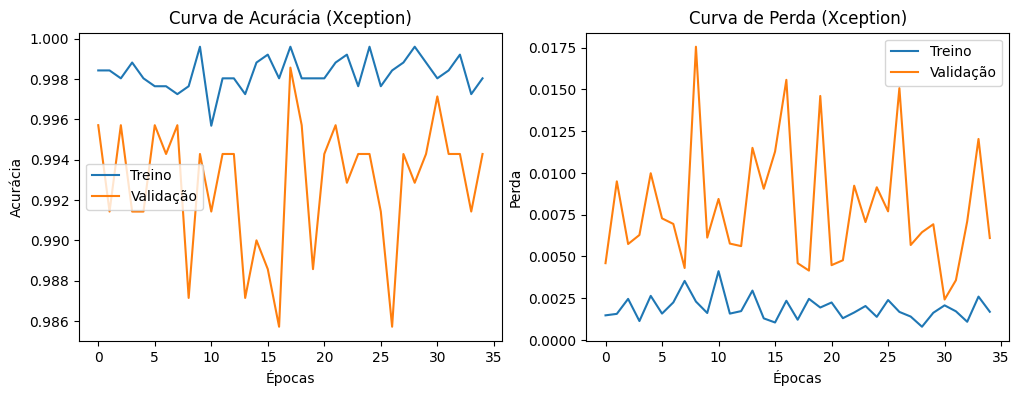

In [ ]:
# Plote as curvas de treino e teste
plt.figure(figsize=(12, 4))

# Plot da Acurácia
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Curva de Acurácia (Xception)')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

# Plot da Perda
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Curva de Perda (Xception)')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

Found 339 images belonging to 7 classes.
11/11 [==============================] - 253s 25s/step


<Figure size 1000x800 with 0 Axes>

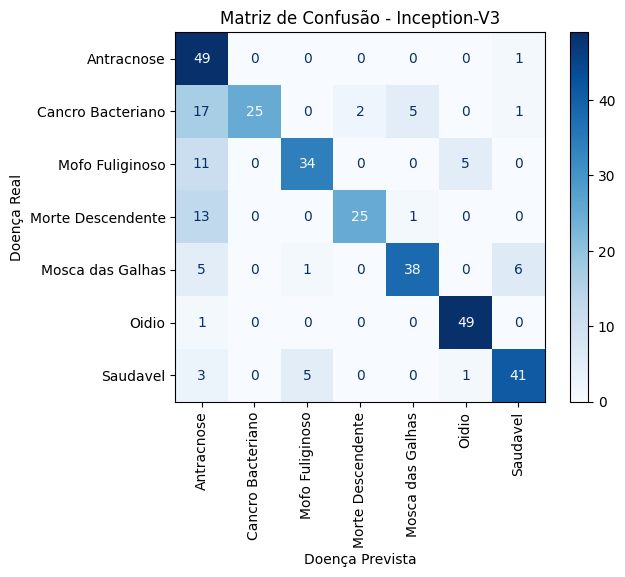

<Figure size 1000x800 with 0 Axes>

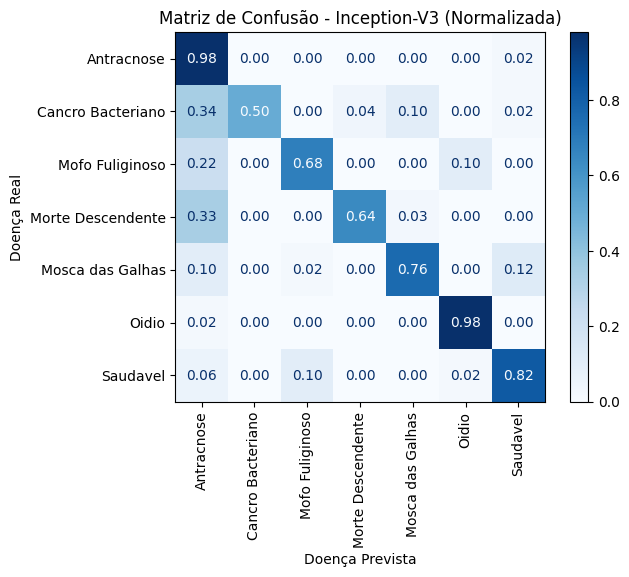

                   precision    recall  f1-score   support

       Antracnose       0.49      0.98      0.66        50
Cancro Bacteriano       1.00      0.50      0.67        50
  Mofo Fuliginoso       0.85      0.68      0.76        50
Morte Descendente       0.93      0.64      0.76        39
 Mosca das Galhas       0.86      0.76      0.81        50
            Oidio       0.89      0.98      0.93        50
         Saudavel       0.84      0.82      0.83        50

         accuracy                           0.77       339
        macro avg       0.84      0.77      0.77       339
     weighted avg       0.83      0.77      0.77       339



In [ ]:
# Importe as bibliotecas necessárias
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import os
#from keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import ConfusionMatrixDisplay

# Carregue o modelo treinado
trained_model = load_model("/content/xception_fold_1.h5")  # Certifique-se de ter o nome correto do arquivo do modelo salvo

# Defina o caminho para a pasta de teste
test_path = '/content/drive/MyDrive/Dataset/Teste'

# Crie um gerador de dados para o conjunto de teste
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(test_path,
                                                  target_size=(224,224),
                                                  batch_size=32,
                                                  class_mode='categorical',
                                                  shuffle=False)

# Faça previsões no conjunto de teste
y_pred = trained_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

class_labels = list(test_generator.class_indices.keys())

# Crie a matriz de confusão
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Plote a matriz de confusão não normalizada com valores absolutos
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay(confusion_mtx, display_labels=class_labels).plot(include_values=True, cmap='Blues', values_format='d')
plt.title('Matriz de Confusão - Inception-V3')
plt.xticks(rotation=90)  # Adicionando rotação aos rótulos do eixo x
plt.xlabel('Doença Prevista')
plt.ylabel('Doença Real')
plt.show()

# Plote a matriz de confusão normalizada com percentuais
plt.figure(figsize=(10, 8))
confusion_mtx_normalized = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis]
ConfusionMatrixDisplay(confusion_mtx_normalized, display_labels=class_labels).plot(include_values=True, cmap='Blues', values_format='.2f')
plt.title('Matriz de Confusão - Inception-V3 (Normalizada)')
plt.xticks(rotation=90)  # Adicionando rotação aos rótulos do eixo x
plt.xlabel('Doença Prevista')
plt.ylabel('Doença Real')
plt.show()

# Exiba métricas de classificação
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

Found 339 images belonging to 7 classes.
11/11 [==============================] - 8s 683ms/step


<Figure size 1000x800 with 0 Axes>

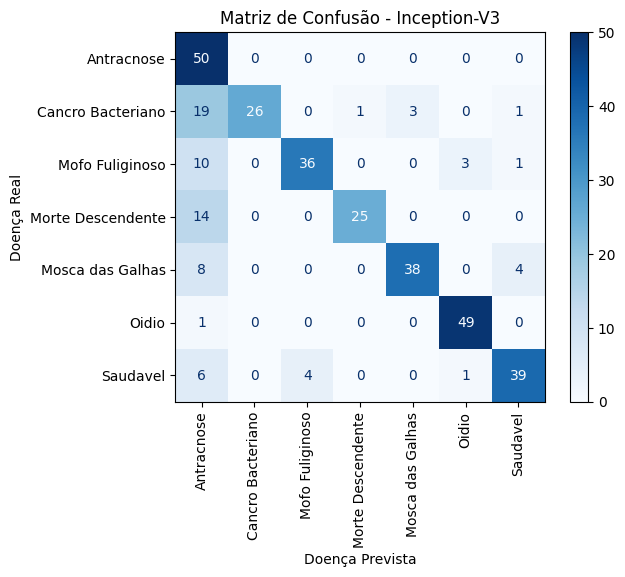

<Figure size 1000x800 with 0 Axes>

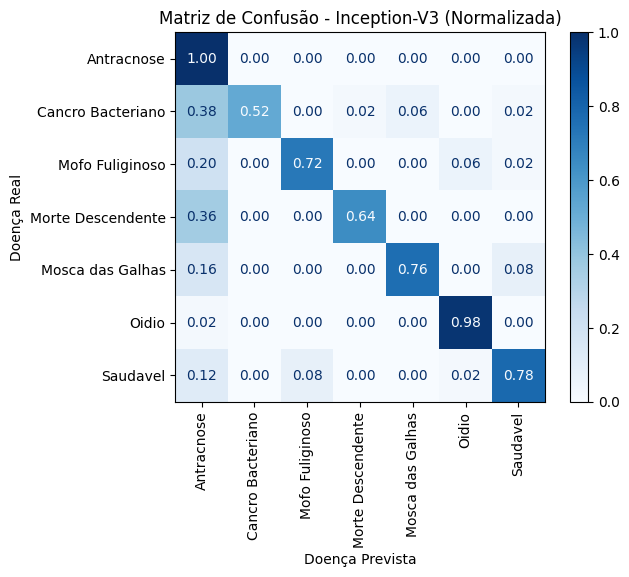

                   precision    recall  f1-score   support

       Antracnose       0.46      1.00      0.63        50
Cancro Bacteriano       1.00      0.52      0.68        50
  Mofo Fuliginoso       0.90      0.72      0.80        50
Morte Descendente       0.96      0.64      0.77        39
 Mosca das Galhas       0.93      0.76      0.84        50
            Oidio       0.92      0.98      0.95        50
         Saudavel       0.87      0.78      0.82        50

         accuracy                           0.78       339
        macro avg       0.86      0.77      0.78       339
     weighted avg       0.86      0.78      0.79       339



In [ ]:
# Importe as bibliotecas necessárias
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import os
#from keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import ConfusionMatrixDisplay

# Carregue o modelo treinado
trained_model = load_model("/content/xception_fold_2.h5")  # Certifique-se de ter o nome correto do arquivo do modelo salvo

# Defina o caminho para a pasta de teste
test_path = '/content/drive/MyDrive/Dataset/Teste'

# Crie um gerador de dados para o conjunto de teste
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(test_path,
                                                  target_size=(224,224),
                                                  batch_size=32,
                                                  class_mode='categorical',
                                                  shuffle=False)

# Faça previsões no conjunto de teste
y_pred = trained_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

class_labels = list(test_generator.class_indices.keys())

# Crie a matriz de confusão
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Plote a matriz de confusão não normalizada com valores absolutos
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay(confusion_mtx, display_labels=class_labels).plot(include_values=True, cmap='Blues', values_format='d')
plt.title('Matriz de Confusão - Inception-V3')
plt.xticks(rotation=90)  # Adicionando rotação aos rótulos do eixo x
plt.xlabel('Doença Prevista')
plt.ylabel('Doença Real')
plt.show()

# Plote a matriz de confusão normalizada com percentuais
plt.figure(figsize=(10, 8))
confusion_mtx_normalized = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis]
ConfusionMatrixDisplay(confusion_mtx_normalized, display_labels=class_labels).plot(include_values=True, cmap='Blues', values_format='.2f')
plt.title('Matriz de Confusão - Inception-V3 (Normalizada)')
plt.xticks(rotation=90)  # Adicionando rotação aos rótulos do eixo x
plt.xlabel('Doença Prevista')
plt.ylabel('Doença Real')
plt.show()

# Exiba métricas de classificação
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

Found 339 images belonging to 7 classes.
11/11 [==============================] - 255s 24s/step


<Figure size 1000x800 with 0 Axes>

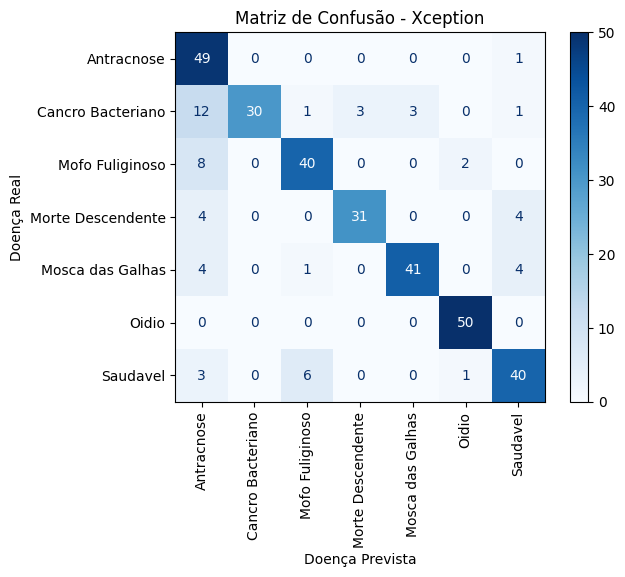

<Figure size 1000x800 with 0 Axes>

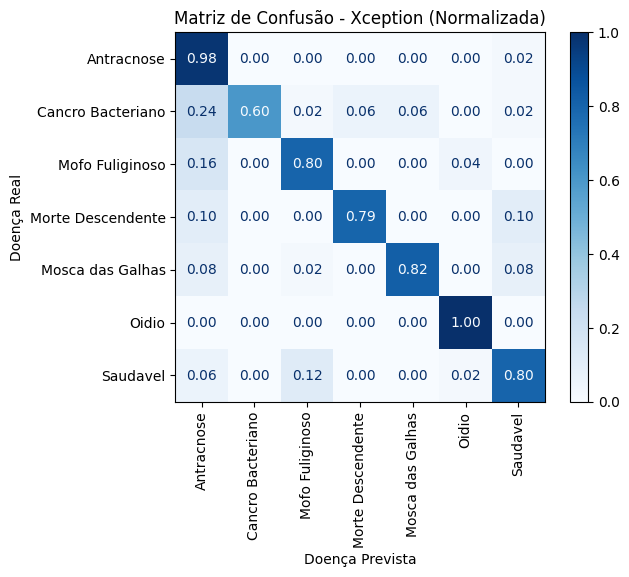

                   precision    recall  f1-score   support

       Antracnose       0.61      0.98      0.75        50
Cancro Bacteriano       1.00      0.60      0.75        50
  Mofo Fuliginoso       0.83      0.80      0.82        50
Morte Descendente       0.91      0.79      0.85        39
 Mosca das Galhas       0.93      0.82      0.87        50
            Oidio       0.94      1.00      0.97        50
         Saudavel       0.80      0.80      0.80        50

         accuracy                           0.83       339
        macro avg       0.86      0.83      0.83       339
     weighted avg       0.86      0.83      0.83       339



In [ ]:
# Importe as bibliotecas necessárias
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import os
#from keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import ConfusionMatrixDisplay

# Carregue o modelo treinado
trained_model = load_model("/content/drive/MyDrive/Modelos_Treinados_3/xception_fold_3.h5")  # Certifique-se de ter o nome correto do arquivo do modelo salvo

# Defina o caminho para a pasta de teste
test_path = '/content/drive/MyDrive/Dataset/Teste'

# Crie um gerador de dados para o conjunto de teste
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(test_path,
                                                  target_size=(224,224),
                                                  batch_size=32,
                                                  class_mode='categorical',
                                                  shuffle=False)

# Faça previsões no conjunto de teste
y_pred = trained_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

class_labels = list(test_generator.class_indices.keys())

# Crie a matriz de confusão
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Plote a matriz de confusão não normalizada com valores absolutos
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay(confusion_mtx, display_labels=class_labels).plot(include_values=True, cmap='Blues', values_format='d')
plt.title('Matriz de Confusão - Xception')
plt.xticks(rotation=90)  # Adicionando rotação aos rótulos do eixo x
plt.xlabel('Doença Prevista')
plt.ylabel('Doença Real')
plt.show()

# Plote a matriz de confusão normalizada com percentuais
plt.figure(figsize=(10, 8))
confusion_mtx_normalized = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis]
ConfusionMatrixDisplay(confusion_mtx_normalized, display_labels=class_labels).plot(include_values=True, cmap='Blues', values_format='.2f')
plt.title('Matriz de Confusão - Xception (Normalizada)')
plt.xticks(rotation=90)  # Adicionando rotação aos rótulos do eixo x
plt.xlabel('Doença Prevista')
plt.ylabel('Doença Real')
plt.show()

# Exiba métricas de classificação
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

Found 339 images belonging to 7 classes.
11/11 [==============================] - 8s 674ms/step


<Figure size 1000x800 with 0 Axes>

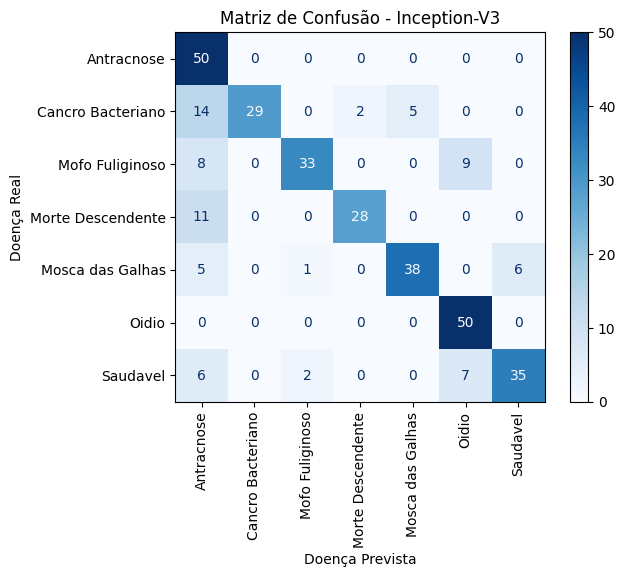

<Figure size 1000x800 with 0 Axes>

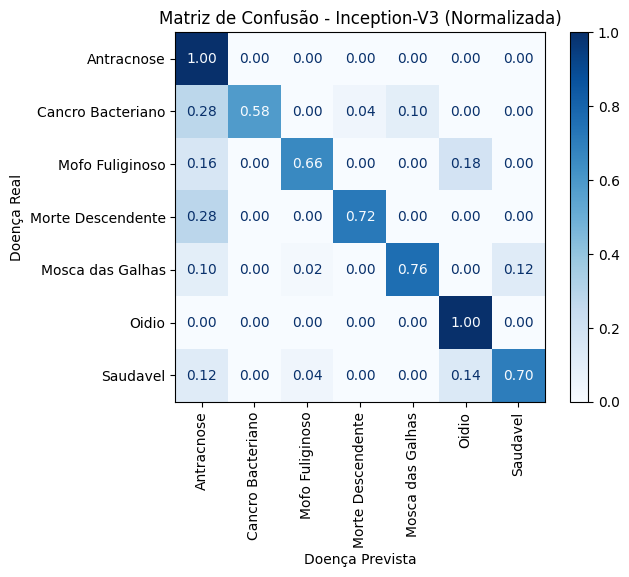

                   precision    recall  f1-score   support

       Antracnose       0.53      1.00      0.69        50
Cancro Bacteriano       1.00      0.58      0.73        50
  Mofo Fuliginoso       0.92      0.66      0.77        50
Morte Descendente       0.93      0.72      0.81        39
 Mosca das Galhas       0.88      0.76      0.82        50
            Oidio       0.76      1.00      0.86        50
         Saudavel       0.85      0.70      0.77        50

         accuracy                           0.78       339
        macro avg       0.84      0.77      0.78       339
     weighted avg       0.84      0.78      0.78       339



In [ ]:
# Importe as bibliotecas necessárias
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import os
#from keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import ConfusionMatrixDisplay

# Carregue o modelo treinado
trained_model = load_model("/content/xception_fold_4.h5")  # Certifique-se de ter o nome correto do arquivo do modelo salvo

# Defina o caminho para a pasta de teste
test_path = '/content/drive/MyDrive/Dataset/Teste'

# Crie um gerador de dados para o conjunto de teste
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(test_path,
                                                  target_size=(224,224),
                                                  batch_size=32,
                                                  class_mode='categorical',
                                                  shuffle=False)

# Faça previsões no conjunto de teste
y_pred = trained_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

class_labels = list(test_generator.class_indices.keys())

# Crie a matriz de confusão
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Plote a matriz de confusão não normalizada com valores absolutos
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay(confusion_mtx, display_labels=class_labels).plot(include_values=True, cmap='Blues', values_format='d')
plt.title('Matriz de Confusão - Inception-V3')
plt.xticks(rotation=90)  # Adicionando rotação aos rótulos do eixo x
plt.xlabel('Doença Prevista')
plt.ylabel('Doença Real')
plt.show()

# Plote a matriz de confusão normalizada com percentuais
plt.figure(figsize=(10, 8))
confusion_mtx_normalized = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis]
ConfusionMatrixDisplay(confusion_mtx_normalized, display_labels=class_labels).plot(include_values=True, cmap='Blues', values_format='.2f')
plt.title('Matriz de Confusão - Inception-V3 (Normalizada)')
plt.xticks(rotation=90)  # Adicionando rotação aos rótulos do eixo x
plt.xlabel('Doença Prevista')
plt.ylabel('Doença Real')
plt.show()

# Exiba métricas de classificação
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

Found 339 images belonging to 7 classes.
11/11 [==============================] - 8s 678ms/step


<Figure size 1000x800 with 0 Axes>

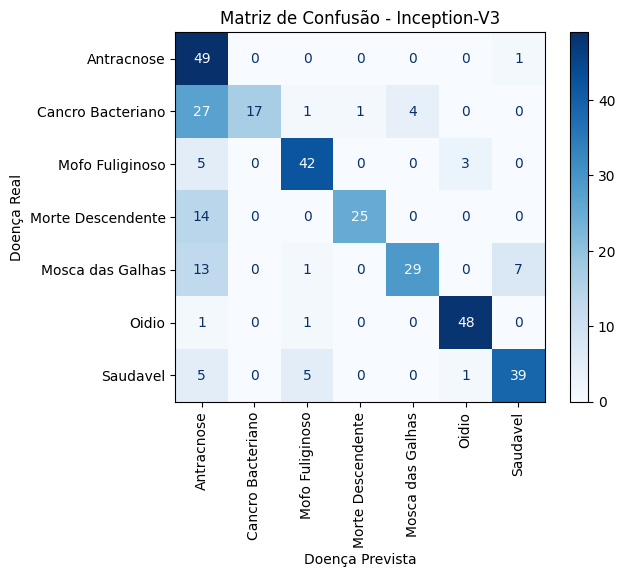

<Figure size 1000x800 with 0 Axes>

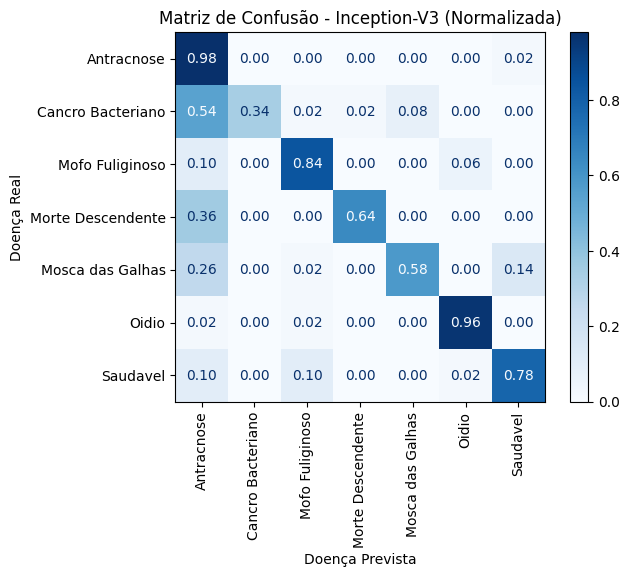

                   precision    recall  f1-score   support

       Antracnose       0.43      0.98      0.60        50
Cancro Bacteriano       1.00      0.34      0.51        50
  Mofo Fuliginoso       0.84      0.84      0.84        50
Morte Descendente       0.96      0.64      0.77        39
 Mosca das Galhas       0.88      0.58      0.70        50
            Oidio       0.92      0.96      0.94        50
         Saudavel       0.83      0.78      0.80        50

         accuracy                           0.73       339
        macro avg       0.84      0.73      0.74       339
     weighted avg       0.83      0.73      0.74       339



In [ ]:
# Importe as bibliotecas necessárias
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import os
#from keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import ConfusionMatrixDisplay

# Carregue o modelo treinado
trained_model = load_model("/content/xception_fold_5.h5")  # Certifique-se de ter o nome correto do arquivo do modelo salvo

# Defina o caminho para a pasta de teste
test_path = '/content/drive/MyDrive/Dataset/Teste'

# Crie um gerador de dados para o conjunto de teste
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(test_path,
                                                  target_size=(224,224),
                                                  batch_size=32,
                                                  class_mode='categorical',
                                                  shuffle=False)

# Faça previsões no conjunto de teste
y_pred = trained_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

class_labels = list(test_generator.class_indices.keys())

# Crie a matriz de confusão
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Plote a matriz de confusão não normalizada com valores absolutos
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay(confusion_mtx, display_labels=class_labels).plot(include_values=True, cmap='Blues', values_format='d')
plt.title('Matriz de Confusão - Inception-V3')
plt.xticks(rotation=90)  # Adicionando rotação aos rótulos do eixo x
plt.xlabel('Doença Prevista')
plt.ylabel('Doença Real')
plt.show()

# Plote a matriz de confusão normalizada com percentuais
plt.figure(figsize=(10, 8))
confusion_mtx_normalized = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis]
ConfusionMatrixDisplay(confusion_mtx_normalized, display_labels=class_labels).plot(include_values=True, cmap='Blues', values_format='.2f')
plt.title('Matriz de Confusão - Inception-V3 (Normalizada)')
plt.xticks(rotation=90)  # Adicionando rotação aos rótulos do eixo x
plt.xlabel('Doença Prevista')
plt.ylabel('Doença Real')
plt.show()

# Exiba métricas de classificação
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

In [ ]:
import shutil

# Especifique os caminhos dos arquivos e pastas
caminho_origem = '/content/xception_fold_3.h5'
caminho_destino = '/content/drive/MyDrive/Modelos_Treinados_3'

# Mova o arquivo para o novo destino
shutil.move(caminho_origem, caminho_destino)

print(f"O arquivo foi movido de {caminho_origem} para {caminho_destino}")

O arquivo foi movido de /content/xception_fold_3.h5 para /content/drive/MyDrive/Modelos_Treinados_3
